# Real-time Bitcoin Data Analysis using Amazon RDS

This notebook demonstrates how to use our Amazon RDS Bitcoin database to perform real-time data analysis. We'll connect to the database, retrieve historical and current data, and perform various time series analyses to understand Bitcoin price movements.

## Key steps in this analysis:
- Connecting to our Amazon RDS PostgreSQL database
- Ensuring database tables are properly set up
- Retrieving historical Bitcoin price data
- Performing basic time series analysis
- Fetching real-time data and adding it to our database
- Creating informative visualizations of price trends

In [1]:
# Import and setup
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import your utility functions
import bitcoin_rds_utils as brds

# Configure basic logging 
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
_LOG = logging.getLogger(__name__)

Check if the enviroment credentials (RDS and API key) are loaded properly


In [2]:
import os
from dotenv import load_dotenv
import psycopg2

# Load environment variables
load_dotenv()

# Print config (with password masked)
config = {
    'host': os.getenv('RDS_HOST'),
    'port': os.getenv('RDS_PORT'),
    'database': os.getenv('RDS_DATABASE'),
    'user': os.getenv('RDS_USER'),
    'password': '********' if os.getenv('RDS_PASSWORD') else None
}
print("Config:", config)

# Test connection
try:
    conn = psycopg2.connect(
        host=os.getenv('RDS_HOST'),
        port=os.getenv('RDS_PORT'),
        database=os.getenv('RDS_DATABASE'),
        user=os.getenv('RDS_USER'),
        password=os.getenv('RDS_PASSWORD')
    )
    print("Successfully connected to the database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Config: {'host': 'bitcoin-price-db.cf8q8ya0ca68.us-east-2.rds.amazonaws.com', 'port': '5432', 'database': 'bitcoin_db', 'user': 'bitcoin', 'password': '********'}
Successfully connected to the database!


In [3]:
# Database connection
# Test the connection to our Amazon RDS PostgreSQL database.
try:
    conn = brds.get_db_connection()
    _LOG.info("Successfully connected to the Amazon RDS PostgreSQL database!")
    
    # Get PostgreSQL version for validation
    cur = conn.cursor()
    cur.execute("SELECT version();")
    db_version = cur.fetchone()
    _LOG.info(f"PostgreSQL database version: {db_version[0]}")
    
    cur.close()
    conn.close()
except Exception as e:
    _LOG.error(f"Failed to connect to the database: {e}")

2025-05-16 21:24:52,377 - bitcoin_rds_utils - INFO - Creating database connection pool
2025-05-16 21:24:52,603 - bitcoin_rds_utils - INFO - Connection pool created with 1-10 connections
2025-05-16 21:24:52,611 - __main__ - INFO - Successfully connected to the Amazon RDS PostgreSQL database!
2025-05-16 21:24:52,679 - __main__ - INFO - PostgreSQL database version: PostgreSQL 17.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit


## Database Setup

First, we ensure our database tables exist. The database uses two main tables:
- `raw_bitcoin_prices`: Stores raw price data points with timestamp
- `hourly_bitcoin_prices`: Stores OHLC (Open, High, Low, Close) aggregated hourly data

In [4]:
# Ensure database tables exist
# Create necessary tables if they don't already exist.
try:
    brds.create_tables_if_not_exist()
    _LOG.info("Tables are ready for Bitcoin data storage!")
except Exception as e:
    _LOG.error(f"Error creating tables: {e}")

2025-05-16 21:24:52,870 - bitcoin_rds_utils - INFO - Creating tables if they don't exist
2025-05-16 21:24:53,201 - bitcoin_rds_utils - INFO - Tables created successfully
2025-05-16 21:24:53,205 - __main__ - INFO - Tables are ready for Bitcoin data storage!


## Data Collection and Storage

Now we'll fetch historical Bitcoin data and store it in our database. We'll use the CoinGecko API through our utility functions to get 30 days of historical data.

In [5]:
# set how many days of bitcoin price data you like
day = 45  # Change this value to whatever number of days you want (2-90)
try:
    _LOG.info("Fetching and storing 60 days of historical Bitcoin data...")
    records_inserted = brds.fetch_and_store_historical_bitcoin_data(days=day)
    _LOG.info(f"Successfully added {records_inserted} historical data points")
except Exception as e:
    _LOG.error(f"Error fetching historical data: {e}")

2025-05-16 21:24:53,401 - __main__ - INFO - Fetching and storing 60 days of historical Bitcoin data...
2025-05-16 21:24:53,409 - bitcoin_rds_utils - INFO - Fetching historical Bitcoin data for the past 45 days
2025-05-16 21:24:53,518 - bitcoin_rds_utils - INFO - Cleared existing data from the past 45 days
2025-05-16 21:24:53,525 - bitcoin_rds_utils - INFO - Making single API call for 45 days of data
2025-05-16 21:24:53,787 - bitcoin_rds_utils - INFO - Received 1080 price data points from API
2025-05-16 21:25:22,081 - bitcoin_rds_utils - INFO - Successfully inserted 1080 new records
2025-05-16 21:25:22,099 - bitcoin_rds_utils - INFO - Historical data fetch complete. Inserted 1080 new records
2025-05-16 21:25:22,125 - __main__ - INFO - Successfully added 1080 historical data points


In [6]:
# Retrieve data for analysis
# Get the historical data from our database for analysis.
try:
    df_history = brds.get_bitcoin_price_history(days=day)
    _LOG.info(f"Retrieved {len(df_history)} records of Bitcoin price history")
    
    # Display the first few rows to understand the data structure
    display(df_history.head())
except Exception as e:
    _LOG.error(f"Error retrieving price history: {e}")

2025-05-16 21:25:22,435 - bitcoin_rds_utils - INFO - Retrieving 45 days of Bitcoin price history (hourly=False)
/project/bitcoin_rds_utils.py:566: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(days,))
2025-05-16 21:25:22,619 - bitcoin_rds_utils - INFO - Retrieved 1080 records of Bitcoin price history
2025-05-16 21:25:22,672 - __main__ - INFO - Retrieved 1080 records of Bitcoin price history


,timestamp,price_usd,volume_usd,market_cap_usd
0,2025-04-01 22:04:42.548,85244.431819,2.935579e+10,1.691908e+12
1,2025-04-01 23:04:52.481,85073.120032,2.967891e+10,1.688787e+12
2,2025-04-02 00:04:51.597,85151.383599,2.967067e+10,1.689880e+12
3,2025-04-02 01:04:54.025,84981.394128,2.684929e+10,1.686026e+12
4,2025-04-02 02:04:56.429,85152.656324,2.710581e+10,1.688804e+12


## Time Series Analysis

With our data retrieved, we can now perform various time series analyses to understand Bitcoin price movements over time.

### 1. Price Trend Visualization

First, let's look at the basic price trend over the past 60 days to understand the overall direction of Bitcoin prices.

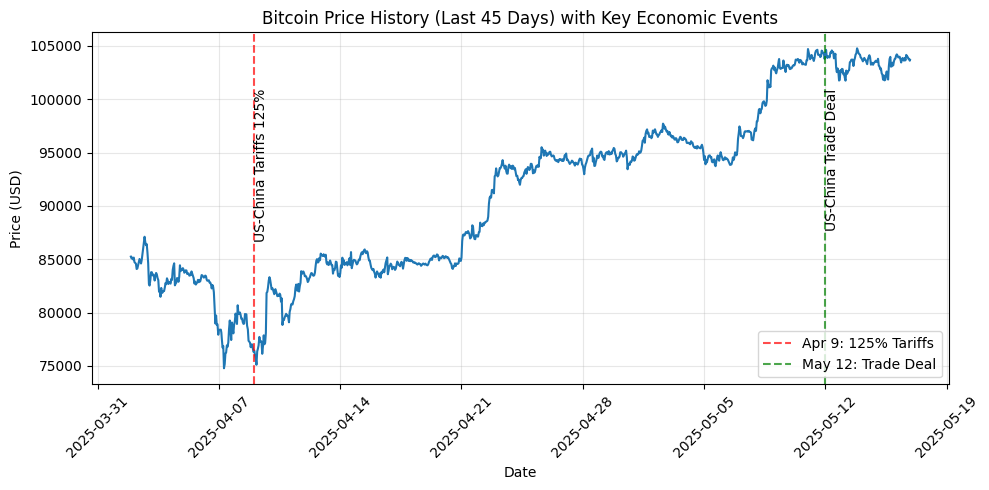


Key Economic Events:
- April 9, 2025: Trump further raised tariffs on Chinese goods to 125%, and China responded with 125% tariffs on U.S. goods.
- May 12, 2025: The U.S. and China reached a temporary trade deal in Geneva. Both sides agreed to slash tariffs for 90 days.
  The U.S. dropped tariffs from 145% to 30%, and China reduced its tariffs on U.S. goods from 125% to 10%.

Price change over 45 days: $18,457.84 (21.65%)
Highest price: $104,778.26
Lowest price: $74,773.26

Impact of US-China 125% Tariffs (Apr 9):
Price 5 days before: $77,152.07
Price at event: $76,300.78
Price 5 days after: $76,346.09
Change 5 days after event: $45.31 (0.06%)

Impact of US-China Trade Deal (May 12):
Price 5 days before: $104,565.15
Price at event: $104,083.02
Price 5 days after: $104,015.38
Change 5 days after event: $-67.64 (-0.06%)

Price change from US-China Tariffs to Trade Deal (33 days):
April 9 price: $76,300.78
May 12 price: $104,083.02
Change: $27,782.24 (36.41%)
Average daily return: 0.95%


In [7]:
if len(df_history) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(df_history['timestamp'], df_history['price_usd'])
    plt.title(f'Bitcoin Price History (Last {day} Days) with Key Economic Events')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, alpha=0.3)
    
    # Add vertical lines for key economic events
    event1_date = pd.to_datetime('2025-04-09')  # US-China Tariffs 125%
    event2_date = pd.to_datetime('2025-05-12')  # US-China Trade Deal
    
    # Add vertical lines if the dates are within our data range
    if (event1_date >= df_history['timestamp'].min()) and (event1_date <= df_history['timestamp'].max()):
        plt.axvline(x=event1_date, color='red', linestyle='--', alpha=0.7)
        plt.text(event1_date, plt.gca().get_ylim()[1]*0.95, 'US-China Tariffs 125%', 
                rotation=90, verticalalignment='top', fontsize=10)
        
    if (event2_date >= df_history['timestamp'].min()) and (event2_date <= df_history['timestamp'].max()):
        plt.axvline(x=event2_date, color='green', linestyle='--', alpha=0.7)
        plt.text(event2_date, plt.gca().get_ylim()[1]*0.95, 'US-China Trade Deal', 
                rotation=90, verticalalignment='top', fontsize=10)
    
    # Add a legend explaining the events
    red_line = plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7)
    green_line = plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.7)
    plt.legend([red_line, green_line], 
              ['Apr 9: 125% Tariffs', 'May 12: Trade Deal'], 
              loc='lower right')
    
    # Format x-axis dates clearly for better visibility
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Adjust tick spacing based on number of days
    if day <= 10:
        interval = 1  # Daily ticks for short periods
    elif day <= 30:
        interval = 3  # Every 3 days for medium periods
    else:
        interval = 7  # Weekly ticks for longer periods
        
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Add event descriptions
    print("\nKey Economic Events:")
    print("- April 9, 2025: Trump further raised tariffs on Chinese goods to 125%, and China responded with 125% tariffs on U.S. goods.")
    print("- May 12, 2025: The U.S. and China reached a temporary trade deal in Geneva. Both sides agreed to slash tariffs for 90 days.")
    print("  The U.S. dropped tariffs from 145% to 30%, and China reduced its tariffs on U.S. goods from 125% to 10%.")
    
    # Calculate and display price change statistics
    latest_price = df_history['price_usd'].iloc[-1]
    earliest_price = df_history['price_usd'].iloc[0]
    price_change = latest_price - earliest_price
    price_change_pct = (price_change / earliest_price) * 100
    
    print(f"\nPrice change over {day} days: ${price_change:,.2f} ({price_change_pct:.2f}%)")
    print(f"Highest price: ${df_history['price_usd'].max():,.2f}")
    print(f"Lowest price: ${df_history['price_usd'].min():,.2f}")
    
    # Analyze impact of trade events if within the date range
    if (event1_date >= df_history['timestamp'].min()) and (event1_date <= df_history['timestamp'].max()):
        # Find nearest data point to the event date
        event1_idx = (df_history['timestamp'] - event1_date).abs().idxmin()
        # Get price 5 days before and 5 days after
        before_idx = max(0, event1_idx - 5)
        after_idx = min(len(df_history) - 1, event1_idx + 5)
        
        price_before = df_history['price_usd'].iloc[before_idx]
        price_event = df_history['price_usd'].iloc[event1_idx]
        price_after = df_history['price_usd'].iloc[after_idx]
        
        print(f"\nImpact of US-China 125% Tariffs (Apr 9):")
        print(f"Price 5 days before: ${price_before:,.2f}")
        print(f"Price at event: ${price_event:,.2f}")
        print(f"Price 5 days after: ${price_after:,.2f}")
        print(f"Change 5 days after event: ${price_after-price_event:,.2f} ({((price_after-price_event)/price_event)*100:.2f}%)")
    
    if (event2_date >= df_history['timestamp'].min()) and (event2_date <= df_history['timestamp'].max()):
        # Find nearest data point to the event date
        event2_idx = (df_history['timestamp'] - event2_date).abs().idxmin()
        # Get price 5 days before and 5 days after
        before_idx = max(0, event2_idx - 5)
        after_idx = min(len(df_history) - 1, event2_idx + 5)
        
        price_before = df_history['price_usd'].iloc[before_idx]
        price_event = df_history['price_usd'].iloc[event2_idx]
        price_after = df_history['price_usd'].iloc[after_idx]
        
        print(f"\nImpact of US-China Trade Deal (May 12):")
        print(f"Price 5 days before: ${price_before:,.2f}")
        print(f"Price at event: ${price_event:,.2f}")
        print(f"Price 5 days after: ${price_after:,.2f}")
        print(f"Change 5 days after event: ${price_after-price_event:,.2f} ({((price_after-price_event)/price_event)*100:.2f}%)")
    
    # Add price change analysis between the two events
    if ((event1_date >= df_history['timestamp'].min()) and (event1_date <= df_history['timestamp'].max()) and
        (event2_date >= df_history['timestamp'].min()) and (event2_date <= df_history['timestamp'].max())):
        
        # Find nearest data points to the event dates
        event1_idx = (df_history['timestamp'] - event1_date).abs().idxmin()
        event2_idx = (df_history['timestamp'] - event2_date).abs().idxmin()
        
        price_event1 = df_history['price_usd'].iloc[event1_idx]
        price_event2 = df_history['price_usd'].iloc[event2_idx]
        
        event_price_change = price_event2 - price_event1
        event_price_change_pct = (event_price_change / price_event1) * 100
        days_between = (event2_date - event1_date).days
        
        print(f"\nPrice change from US-China Tariffs to Trade Deal ({days_between} days):")
        print(f"April 9 price: ${price_event1:,.2f}")
        print(f"May 12 price: ${price_event2:,.2f}")
        print(f"Change: ${event_price_change:,.2f} ({event_price_change_pct:.2f}%)")
        daily_return = (((1 + (event_price_change_pct/100)) ** (1/days_between)) - 1) * 100
        print(f"Average daily return: {daily_return:.2f}%")
else:
    _LOG.warning("Not enough data for visualization.")

### 2. Moving Average Analysis

Moving averages help smooth out price data to identify trends more clearly. We'll calculate both short-term (24-hour) and long-term (7-day) moving averages to understand different time frames.

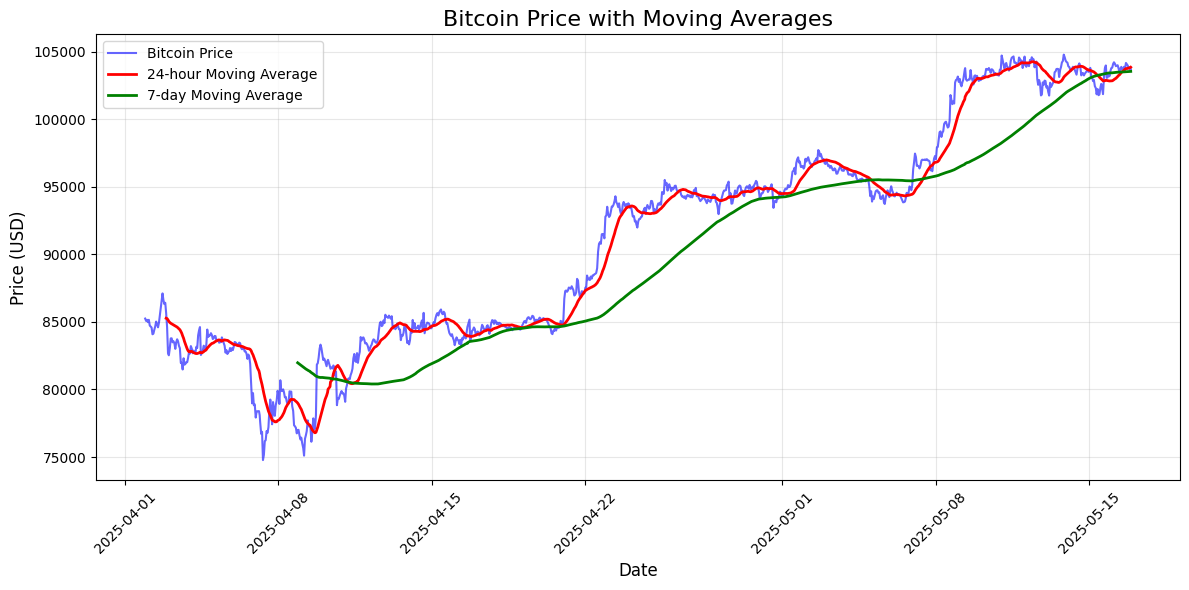

Moving Average Analysis:
- The 24-hour moving average smooths out daily price fluctuations
- The 7-day moving average shows the longer-term trend
- Current short-term trend is above the longer-term trend, suggesting possible upward momentum


In [8]:
# Moving average trend analysis
# Calculate and plot moving averages to identify trends.
try:
    # Ensure data is sorted by timestamp
    df_with_ma = df_history.sort_values('timestamp').copy()
    
    # Calculate 24-hour (short-term) and 7-day (long-term) moving averages
    df_with_ma['MA_24h'] = df_with_ma['price_usd'].rolling(window=24).mean()
    df_with_ma['MA_7d'] = df_with_ma['price_usd'].rolling(window=24*7).mean()
    
    # Plot price with moving averages
    plt.figure(figsize=(12, 6))
    plt.plot(df_with_ma['timestamp'], df_with_ma['price_usd'], 'b-', 
             label='Bitcoin Price', alpha=0.6)
    plt.plot(df_with_ma['timestamp'], df_with_ma['MA_24h'], 'r-', 
             label='24-hour Moving Average', linewidth=2)
    plt.plot(df_with_ma['timestamp'], df_with_ma['MA_7d'], 'g-', 
             label='7-day Moving Average', linewidth=2)
    
    plt.title('Bitcoin Price with Moving Averages', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Provide interpretation of moving average trends
    print("Moving Average Analysis:")
    print("- The 24-hour moving average smooths out daily price fluctuations")
    print("- The 7-day moving average shows the longer-term trend")
    
    # Determine current trend based on moving average relationship
    if df_with_ma['MA_24h'].iloc[-1] > df_with_ma['MA_7d'].iloc[-1]:
        print("- Current short-term trend is above the longer-term trend, suggesting possible upward momentum")
    else:
        print("- Current short-term trend is below the longer-term trend, suggesting possible downward pressure")
except Exception as e:
    _LOG.error(f"Error calculating moving averages: {e}")

### 3. Volume Analysis

Trading volume is a crucial indicator of market activity and can provide insights when analyzed alongside price movements.

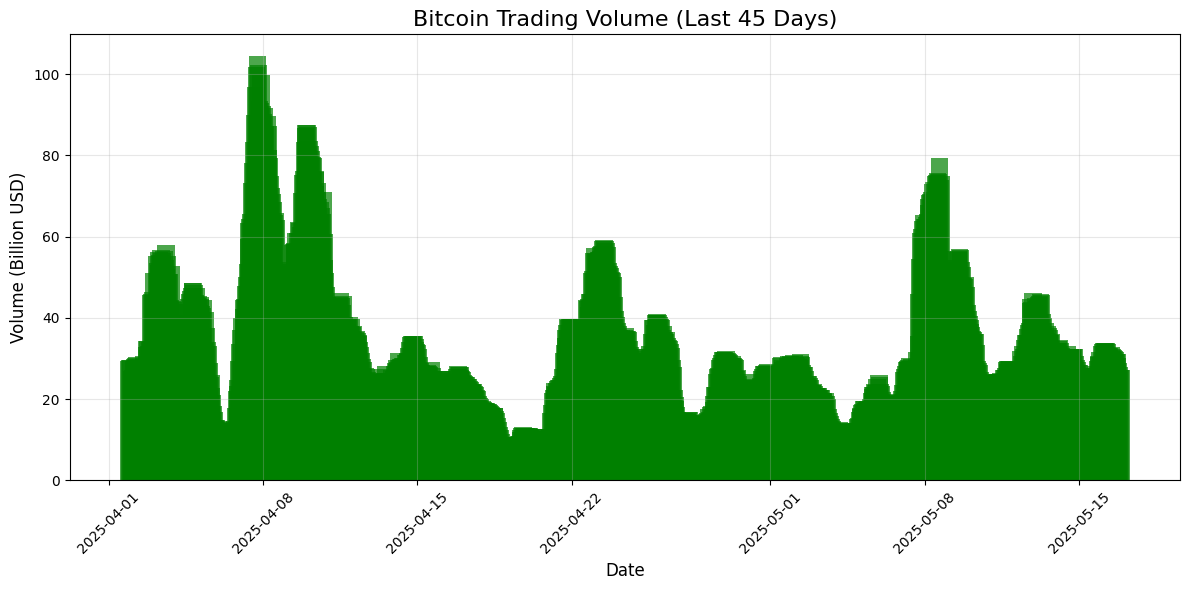

Average daily trading volume: $33.23 billion
Highest trading volume: $104.57 billion on 2025-04-07 18:04:51.047000


In [9]:
# Trading volume analysis
# Analyze Bitcoin trading volume over time.
plt.figure(figsize=(12, 6))
plt.bar(df_history['timestamp'], df_history['volume_usd']/1e9, color='green', alpha=0.7)
plt.title(f'Bitcoin Trading Volume (Last {day} Days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume (Billion USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and display volume statistics
avg_volume = df_history['volume_usd'].mean() / 1e9
max_volume = df_history['volume_usd'].max() / 1e9
max_volume_date = df_history.loc[df_history['volume_usd'].idxmax(), 'timestamp']

print(f"Average daily trading volume: ${avg_volume:.2f} billion")
print(f"Highest trading volume: ${max_volume:.2f} billion on {max_volume_date}")

### 4. Price and Volume Relationship Analysis

By plotting price and volume together, we can examine how they relate to each other and potentially identify patterns where volume precedes price movements.

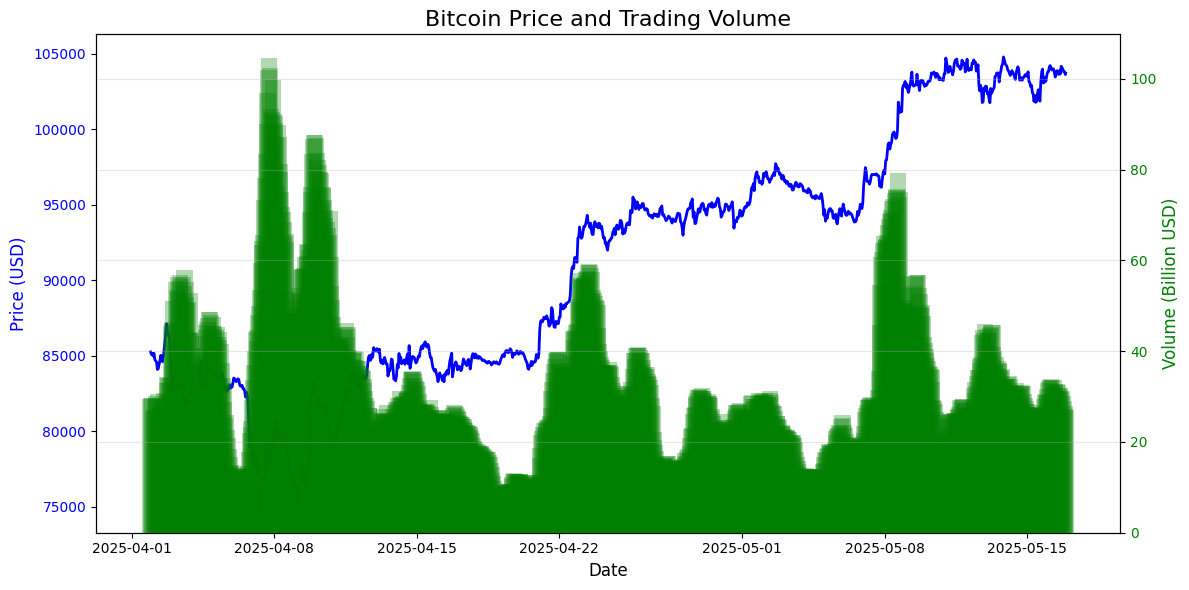

Correlation between price and volume: -0.18
Weak correlation: No strong relationship between price and volume


In [10]:
# Combined price and volume analysis
# Analyze the relationship between price and trading volume.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Price on left y-axis
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price (USD)', color='blue', fontsize=12)
ax1.plot(df_history['timestamp'], df_history['price_usd'], 'b-', linewidth=2)
ax1.tick_params(axis='y', labelcolor='blue')

# Volume on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Volume (Billion USD)', color='green', fontsize=12)
ax2.bar(df_history['timestamp'], df_history['volume_usd']/1e9, color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Bitcoin Price and Trading Volume', fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and interpret correlation between price and volume
correlation = df_history['price_usd'].corr(df_history['volume_usd'])
print(f"Correlation between price and volume: {correlation:.2f}")
if correlation > 0.5:
    print("Strong positive correlation: Price and volume tend to move together")
elif correlation < -0.5:
    print("Strong negative correlation: Price and volume tend to move in opposite directions")
else:
    print("Weak correlation: No strong relationship between price and volume")

### 5. Daily Returns Analysis

Analyzing daily price changes (returns) helps understand volatility and can reveal patterns in market behavior.

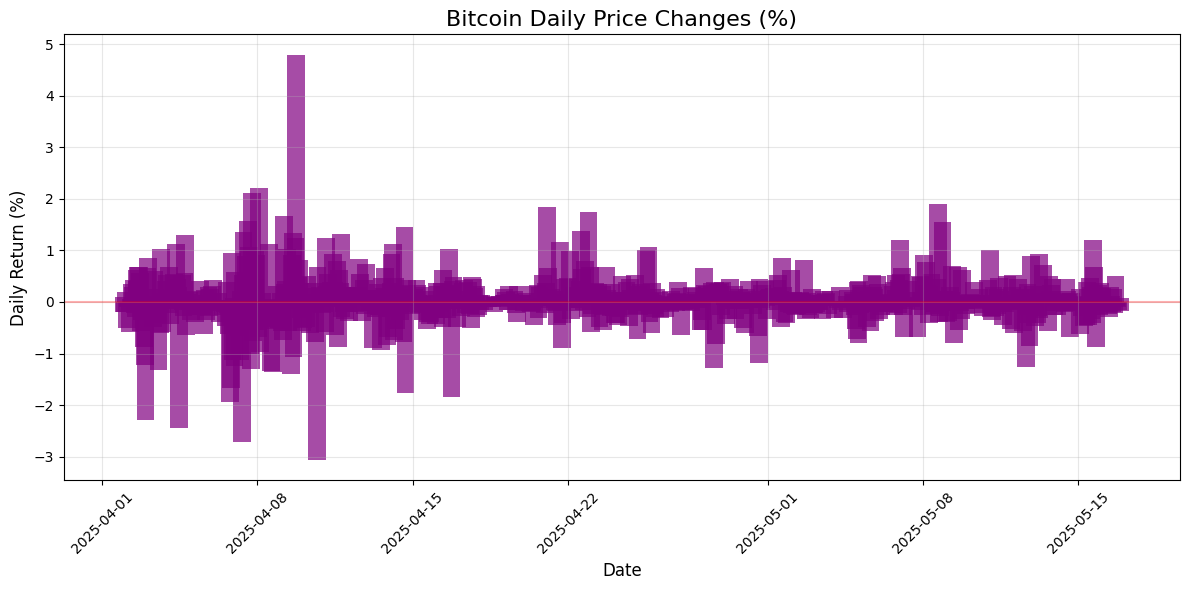

Days with price increase: 556 (51.5%)
Days with price decrease: 522 (48.4%)
Average daily change: 0.02%
Largest daily gain: 4.80%
Largest daily decline: -3.07%


In [11]:
# Daily price changes analysis
# Calculate and visualize daily price changes (returns).
df_history['timestamp'] = pd.to_datetime(df_history['timestamp'])
df_daily = df_history.sort_values('timestamp')
df_daily['daily_return'] = df_daily['price_usd'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.bar(df_daily['timestamp'], df_daily['daily_return'], color='purple', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Bitcoin Daily Price Changes (%)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and display return statistics
positive_days = (df_daily['daily_return'] > 0).sum()
negative_days = (df_daily['daily_return'] < 0).sum()
total_days = df_daily['daily_return'].count()

print(f"Days with price increase: {positive_days} ({positive_days/total_days*100:.1f}%)")
print(f"Days with price decrease: {negative_days} ({negative_days/total_days*100:.1f}%)")
print(f"Average daily change: {df_daily['daily_return'].mean():.2f}%")
print(f"Largest daily gain: {df_daily['daily_return'].max():.2f}%")
print(f"Largest daily decline: {df_daily['daily_return'].min():.2f}%")

### 6. RSI (Relative Strength Index) Analysis

RSI is a momentum oscillator that measures the speed and magnitude of price movements. It ranges from 0 to 100:
- Values above 70 typically indicate overbought conditions (potential price correction downward)
- Values below 30 typically indicate oversold conditions (potential price recovery upward)
- The middle range (40-60) indicates neutral momentum

Let's calculate and visualize the RSI to identify potential buy/sell signals.

2025-05-16 21:25:45,544 - bitcoin_rds_utils - INFO - Calculating 14-period RSI


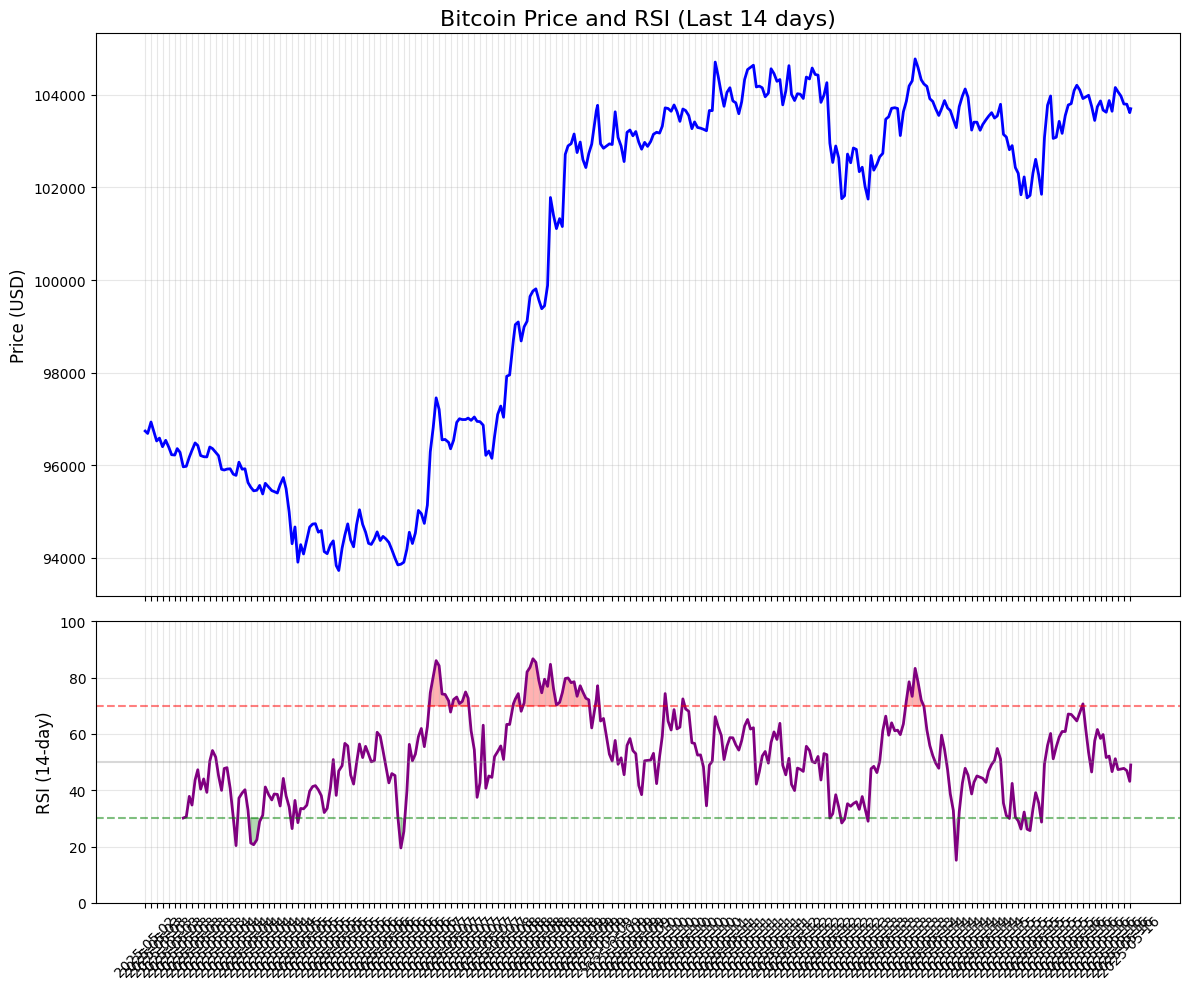

RSI Analysis (Last 14 days):
- Latest RSI value: 49.00
- Current status: NEUTRAL with bearish momentum (RSI below 50)
- Overbought days (RSI > 70): 50 (14.9% of time)
- Oversold days (RSI < 30): 19 (5.7% of time)
- ALERT: Potential RSI divergence detected - price and RSI moving in opposite directions
  * Bullish divergence: Price making lower lows while RSI making higher lows (potential reversal up)


In [12]:
# RSI Technical Analysis
# Calculate the Relative Strength Index and identify potential buy/sell zones
try:
    # Get only the last 14 days of data for RSI calculation
    rsi_days = 14
    df_history_recent = df_history[df_history['timestamp'] >= (df_history['timestamp'].max() - pd.Timedelta(days=rsi_days))].copy()
    
    # Calculate 14-day RSI using our utility function on the filtered data
    df_rsi = brds.calculate_rsi(df_history_recent, window=14)
    
    # Create subplots for price and RSI
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    
    # Plot price in the top subplot
    ax1.plot(df_rsi['timestamp'], df_rsi['price_usd'], 'b-', linewidth=2)
    ax1.set_title(f'Bitcoin Price and RSI (Last {rsi_days} days)', fontsize=16)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot RSI in the bottom subplot
    ax2.plot(df_rsi['timestamp'], df_rsi['rsi'], 'purple', linewidth=2)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)  # Overbought line
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)  # Oversold line
    ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.3)  # Centerline
    ax2.fill_between(df_rsi['timestamp'], 70, df_rsi['rsi'], where=(df_rsi['rsi']>=70), 
                    color='red', alpha=0.3)  # Overbought zone
    ax2.fill_between(df_rsi['timestamp'], 30, df_rsi['rsi'], where=(df_rsi['rsi']<=30), 
                    color='green', alpha=0.3)  # Oversold zone
    ax2.set_ylabel('RSI (14-day)', fontsize=12)
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # Adjust tick spacing for smaller dataset
    ax2.set_xticks(df_rsi['timestamp'][::2])  # Show every 2nd date
    ax2.set_xticklabels(df_rsi['timestamp'].dt.strftime('%Y-%m-%d')[::2], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Rest of the analysis code remains the same
    # Identify potential signals based on RSI
    overbought_days = (df_rsi['rsi'] > 70).sum()
    oversold_days = (df_rsi['rsi'] < 30).sum()
    neutral_days = ((df_rsi['rsi'] >= 30) & (df_rsi['rsi'] <= 70)).sum()
    
    print(f"RSI Analysis (Last {rsi_days} days):")
    print(f"- Latest RSI value: {df_rsi['rsi'].iloc[-1]:.2f}")
    
    # Interpret current RSI value
    latest_rsi = df_rsi['rsi'].iloc[-1]
    if latest_rsi > 70:
        print("- Current status: OVERBOUGHT - Potential sell signal or price correction may occur soon")
    elif latest_rsi < 30:
        print("- Current status: OVERSOLD - Potential buy signal or price recovery may occur soon")
    elif latest_rsi > 50:
        print("- Current status: NEUTRAL with bullish momentum (RSI above 50)")
    else:
        print("- Current status: NEUTRAL with bearish momentum (RSI below 50)")
    
    print(f"- Overbought days (RSI > 70): {overbought_days} ({overbought_days/len(df_rsi)*100:.1f}% of time)")
    print(f"- Oversold days (RSI < 30): {oversold_days} ({oversold_days/len(df_rsi)*100:.1f}% of time)")
    
    # Check for RSI divergence (basic check)
    if len(df_rsi) >= 5:  # Ensure we have enough data points
        last_price_trend = "up" if df_rsi['price_usd'].iloc[-1] > df_rsi['price_usd'].iloc[-5] else "down"
        last_rsi_trend = "up" if df_rsi['rsi'].iloc[-1] > df_rsi['rsi'].iloc[-5] else "down"
        
        if last_price_trend != last_rsi_trend:
            print("- ALERT: Potential RSI divergence detected - price and RSI moving in opposite directions")
            if last_price_trend == "up" and last_rsi_trend == "down":
                print("  * Bearish divergence: Price making higher highs while RSI making lower highs (potential reversal down)")
            else:
                print("  * Bullish divergence: Price making lower lows while RSI making higher lows (potential reversal up)")
except Exception as e:
    _LOG.error(f"Error calculating or plotting RSI: {e}")

## Real-time Data Integration

Now, let's fetch the current Bitcoin price data and add it to our database, demonstrating real-time data collection capabilities.

In [13]:
# Fetch and store current data
# Fetch current Bitcoin data from CoinGecko and store in database.
try:
    current_data = brds.fetch_bitcoin_data_from_coingecko()
    _LOG.info(f"Current Bitcoin price: ${current_data['price_usd']:,.2f}")
    _LOG.info(f"24h Volume: ${current_data['volume_usd']:,.2f}")
    _LOG.info(f"Market Cap: ${current_data['market_cap_usd']:,.2f}")
    
    # Store the current data point
    record_id = brds.insert_raw_bitcoin_data(current_data)
    _LOG.info(f"Successfully stored current data with ID: {record_id}")
    
    # Display the current data
    df_current = pd.DataFrame([current_data])
    df_current['timestamp'] = df_current['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    display(df_current)
except Exception as e:
    _LOG.error(f"Error fetching or storing current Bitcoin data: {e}")

2025-05-16 21:25:50,915 - bitcoin_rds_utils - INFO - Fetching Bitcoin data from CoinGecko
2025-05-16 21:25:51,013 - __main__ - INFO - Current Bitcoin price: $103,703.00
2025-05-16 21:25:51,024 - __main__ - INFO - 24h Volume: $27,180,914,730.00
2025-05-16 21:25:51,031 - __main__ - INFO - Market Cap: $2,060,200,592,739.00
2025-05-16 21:25:51,045 - bitcoin_rds_utils - INFO - Inserting raw Bitcoin data into database
2025-05-16 21:25:51,129 - bitcoin_rds_utils - INFO - Data inserted successfully with ID: 17781
2025-05-16 21:25:51,140 - __main__ - INFO - Successfully stored current data with ID: 17781


,timestamp,price_usd,volume_usd,market_cap_usd,price_change_24h
0,2025-05-16 21:25:51,103703,27180914730,2060200592739,0.63469


## Analysis Summary Dashboard

Finally, let's create a comprehensive dashboard that summarizes our key findings from the time series analysis.

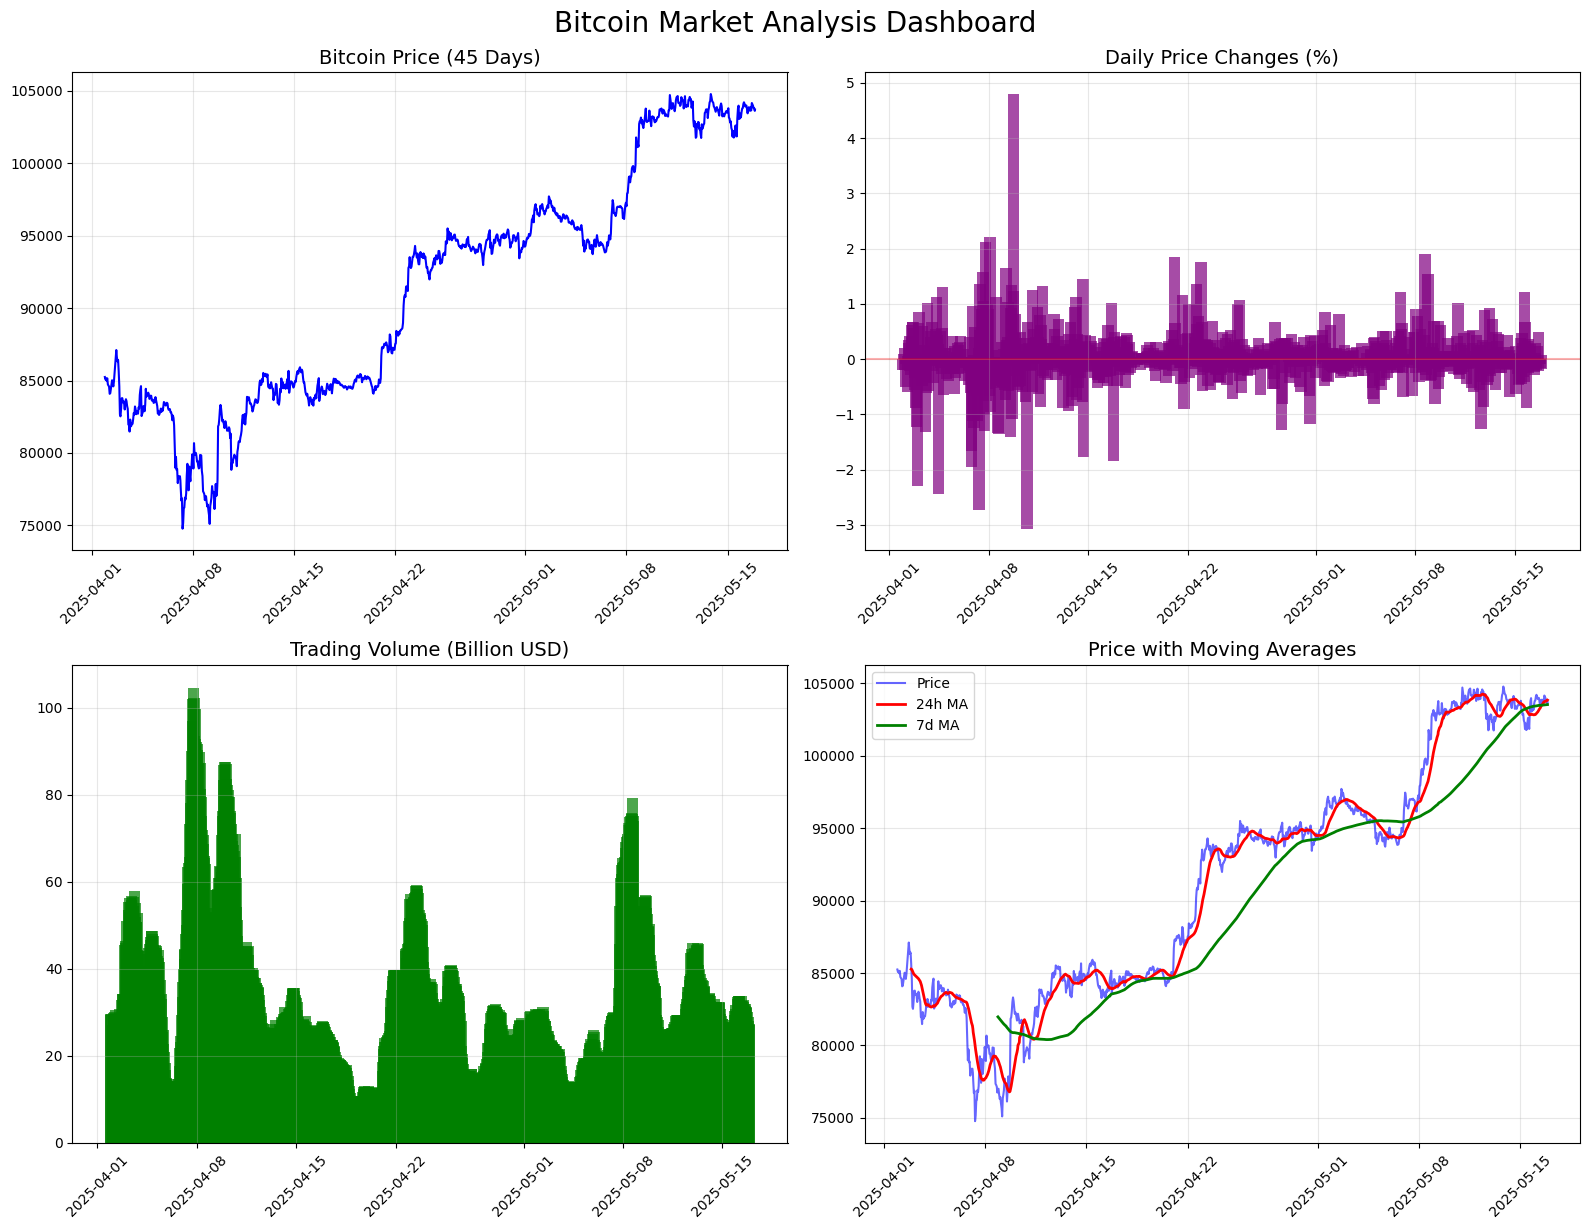

In [14]:
# Summary dashboard
# Create a dashboard with key visualizations and metrics.
plt.figure(figsize=(16, 12))

# 1. Price history
plt.subplot(2, 2, 1)
plt.plot(df_history['timestamp'], df_history['price_usd'], 'b-')
plt.title(f'Bitcoin Price ({day} Days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Daily returns
plt.subplot(2, 2, 2)
plt.bar(df_daily['timestamp'], df_daily['daily_return'], color='purple', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Daily Price Changes (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Volume history
plt.subplot(2, 2, 3)
plt.bar(df_history['timestamp'], df_history['volume_usd']/1e9, color='green', alpha=0.7)
plt.title('Trading Volume (Billion USD)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Price with moving averages
plt.subplot(2, 2, 4)
plt.plot(df_with_ma['timestamp'], df_with_ma['price_usd'], 'b-', label='Price', alpha=0.6)
plt.plot(df_with_ma['timestamp'], df_with_ma['MA_24h'], 'r-', label='24h MA', linewidth=2)
plt.plot(df_with_ma['timestamp'], df_with_ma['MA_7d'], 'g-', label='7d MA', linewidth=2)
plt.title('Price with Moving Averages', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Bitcoin Market Analysis Dashboard', fontsize=20, y=1.02)
plt.show()

## Conclusion and Key Insights

Here we summarize the key findings from our Bitcoin time series analysis.

In [15]:
# Final insights summary
# Provide a comprehensive summary of findings from our analysis.
print("Bitcoin Market Analysis Insights")
print("=" * 40)

# Price trend insights
if df_history['price_usd'].iloc[-1] > df_history['price_usd'].iloc[0]:
    trend = "upward"
else:
    trend = "downward"
    
price_change = df_history['price_usd'].iloc[-1] - df_history['price_usd'].iloc[0]
price_change_pct = (price_change / df_history['price_usd'].iloc[0]) * 100

print(f"1. Price Trend: {trend.capitalize()} trend over the last {day} days")
print(f"   - Net change: ${price_change:,.2f} ({price_change_pct:.2f}%)")
print(f"   - Current price: ${df_history['price_usd'].iloc[-1]:,.2f}")

# Volatility insights
avg_abs_change = df_daily['daily_return'].abs().mean()
print(f"\n2. Market Volatility:")
print(f"   - Average daily change: {avg_abs_change:.2f}%")
if avg_abs_change > 3:
    print("   - Highly volatile market conditions")
elif avg_abs_change > 1:
    print("   - Moderate market volatility")
else:
    print("   - Relatively stable market conditions")

# Volume insights
avg_volume = df_history['volume_usd'].mean() / 1e9
recent_volume_avg = df_history['volume_usd'].tail(7).mean() / 1e9
volume_change_pct = ((recent_volume_avg / avg_volume) - 1) * 100

print(f"\n3. Trading Volume:")
print(f"   - {day}-day average volume: ${avg_volume:.2f} billion")
print(f"   - Recent 7-day average: ${recent_volume_avg:.2f} billion ({volume_change_pct:.2f}% compared to {day}-day average)")

# Technical indicators
short_ma = df_with_ma['MA_24h'].iloc[-1]
long_ma = df_with_ma['MA_7d'].iloc[-1]
ma_diff = ((short_ma / long_ma) - 1) * 100

print(f"\n4. Technical Indicators:")
if short_ma > long_ma:
    print(f"   - Short-term MA is above long-term MA by {ma_diff:.2f}%, suggesting bullish momentum")
else:
    print(f"   - Short-term MA is below long-term MA by {abs(ma_diff):.2f}%, suggesting bearish pressure")

print("\nData Quality Statistics:")
print(f"- Total data points in analysis: {len(df_history)}")
print(f"- Database timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Bitcoin Market Analysis Insights
1. Price Trend: Upward trend over the last 45 days
   - Net change: $18,457.84 (21.65%)
   - Current price: $103,702.27

2. Market Volatility:
   - Average daily change: 0.31%
   - Relatively stable market conditions

3. Trading Volume:
   - 45-day average volume: $33.23 billion
   - Recent 7-day average: $29.10 billion (-12.43% compared to 45-day average)

4. Technical Indicators:
   - Short-term MA is above long-term MA by 0.30%, suggesting bullish momentum

Data Quality Statistics:
- Total data points in analysis: 1080
- Database timestamp: 2025-05-16 21:26:00
